# **Wstęp teoretyczny - po co nam testowanie?**

## **Historyjka**


Hipotetyczna sytuacja - jesteśmy dyrektorem w firmie zajmującej się produkcją części samochodowych. Mamy dwa zakłady produkcyjne A i B, oba produkują między innymi alternatory. Chcemy się dowiedzieć jak wygląda jakość produkowanych części, więc pobieramy po kilka sztuk z każdego zakładu i okazuje się że w zakładzie A 20% ma wady, w zakładzie B 30% ma wady.

$p_A = 0,2$

$p_B = 0,3$


Wypadało by zaplanować jakieś działania naprawcze w zakładzie B. Na przykład dodatkowe szkolenia, albo  wizytę pracowników z zakładu B w zakładzie A, żeby sobie zobaczyli jak robić dobre alternatory.

Ale chwila - czy ta różnica w ilości wadliwych egzemplarzy jest na prawdę taka duża? Co jeśli wylosowaliśmy tylko 10 sztuk części z każdego zakładu? Czyli z zakładu A były 2 sztuki wadliwe, z zakładu B 3 wadliwe. Może akurat tak się trafiło, że dla B przypadkiem wylosowaliśmy jeden niesprawny więcej niż w A. Różnicy w udziale procentowym niesprawnych części może tak na prawdę nie być, wypadało by zbadać więcej sztuk.

Gdyby tych losowanych sztuk było 10000, szansa że fabryki mają taką samą jakość, a my przypadkowo wylosowaliśmy 1000 niesprawnych sztuk więcej w B jest oczywiście mniejsza.

A co jak losowanych sztuk było 100? Albo 20? Gdzie jest ta granica, gdy możemy stwierdzić, że jest istotna różnica w odsetku braków? Na takie pytania odpowiadają testy istotności.

## Wyjaśnienie

Wynik każdego losowania z populacji (a nasze dane to też losowanie, bo nie mamy dostępu do wszystkich przeszłych i przyszłych rezerwacji wizyt) to zmienna losowa, która ma jakąś wartość i jakąś niepewność. Wielkości te można przedstawić graficznie:
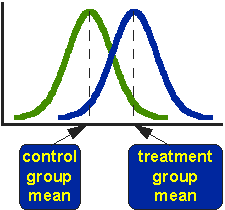 
Obrazki kradzione z https://conjointly.com/kb/statistical-student-t-test/

Maksimum każdej krzywej to nasz odsetek, a to jak bardzo krzywa jest "rozstrzelona" świadczy o niepewności pomiaru. Widzimy, że jest pewien zakres, w którym te krzywe się pokrywają. **Prawdopodobieństwo, że pomiędzy dwoma grupami nie ma istotnej różnicy** jest proporcjonalne do pola powierzchni wspólnego dla tych krzywych. Tą wartość nazywamy **p-value** i to jest właśnie to, co otrzymamy z testów statystycznych. (rysunki przedstawiają testy dla wartości średnich, ale dla odsetka jest podobnie)

Im większa różnica pomiędzy grupami, tym wspólne pole będzie mniejsze. Im większa niepewność wartości w poszczególnych grupach, tym wykresy będą szersze a pole większe. Można to zobaczyć na rysunkach:

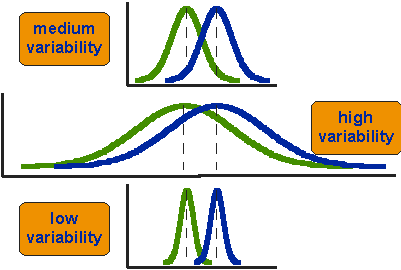

Można też testowanie porównać do określania stosunku sygnału do szumu - im większy sygnał, tym bardziej jesteśmy pewni że to prawdziwy sygnał a nie fluktuacja szumu. W tym przypadku sygnałem jest różnica między odsetkami a szumem niepewność tej różnicy.

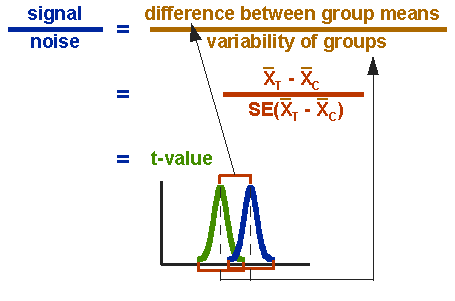

Dla testów odsetka zamiast t-value będziemy mieć statystykę Z

## Jak to policzyć?
Wzór w Wikipedii:
https://pl.wikipedia.org/wiki/Test_dla_proporcji#Test_dla_dw%C3%B3ch_pr%C3%B3b_du%C5%BCych

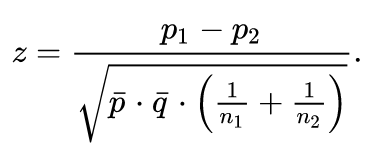

na podstawie liczebności obu grup i ilości wystąpień poszczególnej cechy w każdej grupie (cecha to popsuty alternator, nieprzyjście na wizyte) obliczamy wartość statystyki Z. Następnie z tablic rozkładu normalnego, albo z gotowych funkcji wyznaczamy p-value i tyle. Mamy prawdopodobieństwo z jakim poziom cechy w danych grupach jest różny.

## Co z tego mamy?
W kontekście ML raczej nie wiele. Możemy sprawdzić czy jakaś zmienna ma wpływ na interesującą nas zmienną. Jeśli statystycznie prawdopodobieństwo na to jest małe, raczej nie spodziewałbym się, że ta zmienna pojawi się jako istotna dla modelu. Ale mogą istnieć jakieś zależności drugiego i dalszego poziomu, które sprawią, że ta zmienna i tak nam wskoczy do modelu.

Jeśli uzyskamy wynik, że jakaś zmienna bardzo istotnie różnicuje, to nie oznacza też, że pojawi się ona jako istotna w modelu. 

Do czego mogą się więc te testy przydać? Wymyśliłem dwa zastosowania:
- wstępna analiza - sprawdzamy, czy różnica, którą widzimy na wykresie i na którą się bardzo napaliliśmy, jest tak naprawdę jakąś znaczącą różnicą
- bardzo duża ilość cech - jeśli mamy tyle zmiennych, że modele się krztuszą, można porobić testy i wywalić część z nich, ten z największym p-value, dlatego że on raczej wiele nie wnosi

## Jakie p-value jest dobre?
W statystyce przyjęły się trzy poziomy:
- **p_value < 0,1** - no od biedy można powiedzieć, że dwie grupy się różnią
- **p_value < 0,05** - na 95% grupy się różnią, czyli już jesteśmy dość pewni
- **p_value < 0,01** - tutaj to już prawie na pewno poziom cechy w obu grupach jest różny. Jest mniej niż 1% szansy, że różnica wynika z przypadku (czyli źle się wylosowało)

Aha nie mylcie p (odsetek) z p_value, to są kompletnie różne rzeczy :)

In [8]:
def z_test_for_two_fractions(m1, m2, n1, n2):
  '''
  To jest implementacja funkcji z Wikipedii. Bierze liczebności i zwraca p-value,
  czyli prawdopodobieństwo że grupy są takie same. 
  '''
  if n1 == 0 or n2 == 0:
    print("can't perform test, one group is empty")
    return -1
  if n1 < 20 or n2 < 20:
    print("Samples are small: ({} and {}), risk that results will be not accurate"
    .format(n1, n2))

  p = (m1+m2)/(n1+n2)
  p1 = m1/n1
  p2 = m2/n2
  z = abs((p1 - p2) / np.sqrt(p*(1-p)*((1/n1) + (1/n2))))
  p_value = (1- stats.norm.cdf(z))/2

# wypiszemy sobie jakiś słowny opis co ten wynik znaczy
  if p_value < 0.01:
    result = "Very signigicant difference"
  elif p_value < 0.05:
    result = "Some significant difference"
  elif p_value < 0.1:
    result = "Weak significant difference"
  else:
    result = "No significant difference"

# wypisuje wszystkie mniej lub bardziej ważne parametry, które się liczyły
  print(f"p1 = {p1:.3}, p2 = {p2:.3}, z={z:{.2}}, p-value = {p_value:.3}, {result}")
 
  return p_value

In [9]:
def test_proportion(df, grouping_variable, tested_variable):
  '''
  Ta funkcja bierze df i nazwy dwóch zmiennych, grouping_variable to ta, której 
  wpływ chcemy zbadać (np Alkoholizm w pytaniu czy alkoholizm wpływa na szansę
  no-showa?), czyli zmienna definiujące dwie lub więcej grup. Tested-variable to
  ta zmienna, dla której chcemy sprawdzić, czy jest różnica pomiędzy grupami (u
  nas No-show) 
  '''
  print(grouping_variable),

  # zmienna testowa powinna mieć max dwie wartości
  assert len(df[tested_variable].value_counts()) <= 2

  # zmienna grupująca może mieć więcej niż dwie wartości (np Neighberhood), 
  # ale test można zrobićtylko jeśli ma dwie. Sprawdzam czy jest więcej niż
  # dwie wartości, jeśli tak to robie one-hot-encoding i sprawdzam wpływ każdej 
  # oddzielnie - np Neighbourhood_AEROPORTO vs No-Show, potem Neighbourhood_ANDORINHAS
  # vs No-Show itd

  if len(df[grouping_variable].value_counts()) > 2:
     dummies = pd.get_dummies(df[grouping_variable], 
                              prefix = grouping_variable)
     for column in dummies.columns:
       temp_df = pd.concat([dummies[column], df[tested_variable]], axis=1)
       test_proportion(temp_df, column, tested_variable) # requrently calling again
     return # exit from requrency

  
  df_copy = df.copy()  

  df_copy[grouping_variable] = df_copy[grouping_variable].factorize()[0] # to change yes/no tak/nie into 0/1
  df_copy[tested_variable] = df_copy[tested_variable].factorize()[0]

  n1 = df_copy[grouping_variable].sum()  # how many from grouping are ones
  n2 = len(df_copy) - n1                 # how many from grouping are zeros

  m2 = df_copy[df_copy[grouping_variable]==0][tested_variable].sum()  # tested ones when grouping zero
  m1 = df_copy[df_copy[grouping_variable]==1][tested_variable].sum()  # tested ones when grouping one

  
  return z_test_for_two_fractions(m1, m2, n1, n2)
  


In [24]:
import pandas as pd
import numpy as np
from scipy import stats
pd.set_option("display.precision", 2)

In [11]:
# wczytuje oryginalne dane (bo będę sprawdzał oryginalne Neighberhood)
%cd '/content/drive/MyDrive/Colab Notebooks/dwf_warszawa/'
df = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/dwf_warszawa/KaggleV2-May-2016.csv")

/content/drive/MyDrive/Colab Notebooks/dwf_warszawa


In [12]:
# wybrani odpowiednich kolumn, wywaleni zmiennych ciągłych
all_numeric = list(df.select_dtypes(include=np.number).columns)
all_numeric.remove('PatientId')
all_numeric.remove('Age')
all_numeric.remove('AppointmentID')
all_numeric.remove('Handcap')

significant = {}
not_significant = {}
for variable in all_numeric:
  p_value = test_proportion(df, variable, "No-show")
  if p_value < 0.1 and p_value > -0.5: # to drugie porównanie, bo jak nie może przetestować to zwraca -1
    significant[variable] = p_value
  else:
    not_significant[variable] = p_value


Scholarship
p1 = 0.237, p2 = 0.198, z=9.7, p-value = 0.0, Very signigicant difference
Hipertension
p1 = 0.209, p2 = 0.173, z=1.2e+01, p-value = 0.0, Very signigicant difference
Diabetes
p1 = 0.18, p2 = 0.204, z=5.0, p-value = 1.12e-07, Very signigicant difference
Alcoholism
p1 = 0.201, p2 = 0.202, z=0.065, p-value = 0.237, No significant difference
SMS_received
p1 = 0.276, p2 = 0.167, z=4.2e+01, p-value = 0.0, Very signigicant difference


##Uwaga
Wartość p-value = 0.0 oznacza, że ułamek jest tak mały że zabrakło precyzji żeby go pokazać. Prawdopodobieństwo, że grupy się różnią to w zasadzie 100%

In [25]:
pd.DataFrame(significant, index=["p-value"])

,Scholarship,Hipertension,Diabetes,SMS_received
p-value,0.0,0.0,1.12e-07,0.0


In [23]:
test_proportion(df, "Handcap", "No-show")

Handcap
Handcap_0
p1 = 0.182, p2 = 0.202, z=2.4, p-value = 0.00387, Very signigicant difference
Handcap_1
p1 = 0.179, p2 = 0.202, z=2.6, p-value = 0.00248, Very signigicant difference
Handcap_2
p1 = 0.202, p2 = 0.202, z=0.0085, p-value = 0.248, No significant difference
Handcap_3
Samples are small: (13 and 110514), risk that results will be not accurate
p1 = 0.231, p2 = 0.202, z=0.26, p-value = 0.199, No significant difference
Handcap_4
Samples are small: (3 and 110524), risk that results will be not accurate
p1 = 0.333, p2 = 0.202, z=0.57, p-value = 0.143, No significant difference
Empty DataFrame
Columns: []
Index: []


In [27]:
test_proportion(df, "Neighbourhood", "No-show")

Neighbourhood
Neighbourhood_AEROPORTO
Samples are small: (8 and 110519), risk that results will be not accurate
p1 = 0.125, p2 = 0.202, z=0.54, p-value = 0.147, No significant difference
Neighbourhood_ANDORINHAS
p1 = 0.23, p2 = 0.201, z=3.4, p-value = 0.000169, Very signigicant difference
Neighbourhood_ANTÔNIO HONÓRIO
p1 = 0.185, p2 = 0.202, z=0.72, p-value = 0.119, No significant difference
Neighbourhood_ARIOVALDO FAVALESSA
p1 = 0.22, p2 = 0.202, z=0.75, p-value = 0.113, No significant difference
Neighbourhood_BARRO VERMELHO
p1 = 0.215, p2 = 0.202, z=0.68, p-value = 0.125, No significant difference
Neighbourhood_BELA VISTA
p1 = 0.201, p2 = 0.202, z=0.062, p-value = 0.238, No significant difference
Neighbourhood_BENTO FERREIRA
p1 = 0.225, p2 = 0.202, z=1.7, p-value = 0.023, Some significant difference
Neighbourhood_BOA VISTA
p1 = 0.186, p2 = 0.202, z=0.71, p-value = 0.12, No significant difference
Neighbourhood_BONFIM
p1 = 0.198, p2 = 0.202, z=0.48, p-value = 0.158, No significant diff